# 1. Setup

### Download Dataset

Download the FloodNet dataset uploaded on my GDrive. Pre-process the data to combine all the files for test, val, and train set into one folder. 

Download and unzip the files


In [ ]:
!pip install gdown

In [ ]:
!gdown 1DPbnKFgLecfOIKEV371Q0WoldtuUrMcr
!gdown 1JOgQy3dfZMywEd-YZqlru8eS-4LwM3n6 
!gdown 1MLBYal4fvk6hYF7CvKJtDEiq6tQYPrwB 
!gdown 1OzZoALUQ3_diA4i0ddnoAnng5bQr0djq 
!gdown 1Z_FAxQNs2tGn9MAUgqYqFoFQFw9DMhYk 
!gdown 1_l3bjvrDU8DGu2BdjJldi8kcqVWr6_Y_ 
!gdown 1mSeNA9rr078JBDdZz-IfABVACeBSA-BK

In [ ]:
for i in range(1,8):
    !unzip FloodNet-Supervised_v1.0-20230312T110216Z-00{i}.zip
    !mv FloodNet-Supervised_v1.0 FloodNet-Supervised_v1.0_{i}
    !rm FloodNet-Supervised_v1.0-20230312T110216Z-00{i}.zip

Check if the filenames are all unique and come in pairs. And then transfer them to 'test', 'val', and 'train' directories

In [7]:
import os
from pathlib import Path
import shutil
import glob

import numpy as np

In [ ]:
# get glob of datasets
dir_base = 'FloodNet-Supervised_v1.0_'
test_lbl = []
test_org = []
train_lbl = []
train_org = []
val_lbl = []
val_org = []
for i in range(1, 8):
    test_lbl += glob.glob(f'{dir_base}{i}/test/test-label-img/*.png')
    test_org += glob.glob(f'{dir_base}{i}/test/test-org-img/*.jpg')
    train_lbl += glob.glob(f'{dir_base}{i}/train/train-label-img/*.png')
    train_org += glob.glob(f'{dir_base}{i}/train/train-org-img/*.jpg')
    val_lbl += glob.glob(f'{dir_base}{i}/val/val-label-img/*.png')
    val_org += glob.glob(f'{dir_base}{i}/val/val-org-img/*.jpg')

In [ ]:
_test_lbl = list(map(lambda x:x.split('/')[-1], test_lbl))
_test_org = list(map(lambda x:x.split('/')[-1], test_org))
_train_lbl = list(map(lambda x:x.split('/')[-1], train_lbl))
_train_org = list(map(lambda x:x.split('/')[-1], train_org))
_val_lbl = list(map(lambda x:x.split('/')[-1], val_lbl))
_val_org = list(map(lambda x:x.split('/')[-1], val_org))

assert len(np.unique(_test_lbl)) == len(_test_lbl)
assert len(np.unique(_test_org)) == len(_test_org)
assert len(np.unique(_train_lbl)) == len(_train_lbl)
assert len(np.unique(_train_org)) == len(_train_org)
assert len(np.unique(_val_lbl)) == len(_val_lbl)
assert len(np.unique(_val_org)) == len(_val_org)

In [ ]:
print(len(test_lbl), len(test_org), len(train_lbl), len(train_org), len(val_lbl), len(val_org))


In [ ]:

train_dir = 'train'
test_dir = 'test'
val_dir = 'val'

os.makedirs(train_dir,exist_ok=True)
os.makedirs(test_dir,exist_ok=True)
os.makedirs(val_dir,exist_ok=True)

In [ ]:

list(map(lambda x:shutil.move(x, f'{test_dir}/{Path(x).name}'), test_lbl))
list(map(lambda x:shutil.move(x, f'{test_dir}/{Path(x).name}'), test_org))
list(map(lambda x:shutil.move(x, f'{train_dir}/{Path(x).name}'), train_lbl))
list(map(lambda x:shutil.move(x, f'{train_dir}/{Path(x).name}'), train_org))
list(map(lambda x:shutil.move(x, f'{val_dir}/{Path(x).name}'), val_lbl))
list(map(lambda x:shutil.move(x, f'{val_dir}/{Path(x).name}'), val_org))

In [ ]:
print(len(glob.glob('train/*.png')), len(glob.glob('test/*.png')), len(glob.glob('val/*.png')))
print(len(glob.glob('train/*.jpg')), len(glob.glob('test/*.jpg')), len(glob.glob('val/*.jpg')))

In [ ]:
!rm -r FloodNet-Supervised_v1.0_1
!rm -r FloodNet-Supervised_v1.0_2
!rm -r FloodNet-Supervised_v1.0_3
!rm -r FloodNet-Supervised_v1.0_4
!rm -r FloodNet-Supervised_v1.0_5
!rm -r FloodNet-Supervised_v1.0_6
!rm -r FloodNet-Supervised_v1.0_7

## Setup

In [ ]:
!ls /kaggle/input

In [2]:
import os
from pathlib import Path

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.optim.lr_scheduler import ExponentialLR


from tqdm.notebook import tqdm

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cpu


# 2. Analyze Data
Visualize some images and GT (ground truths).

In [5]:
train_dir = Path(os.path.join("/kaggle", "working", "train"))
test_dir = Path(os.path.join("/kaggle", "working", "test"))
val_dir = Path(os.path.join("/kaggle", "working", "val"))



In [7]:
def img_label(dirpath, imgname):
    image_org = Image.open(dirpath/f'{imgname}.jpg').convert('RGB')
    image_lbl = Image.open(dirpath/f'{imgname}_lab.png')
    return np.array(image_org), np.array(image_lbl)


In [5]:
def hide_ticks_labels(ax):
    # Hide X and Y axes label marks
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)

    # Hide X and Y axes tick marks
    ax.set_xticks([])
    ax.set_yticks([])

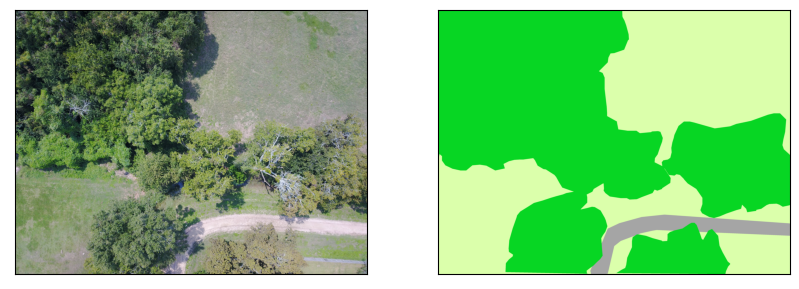

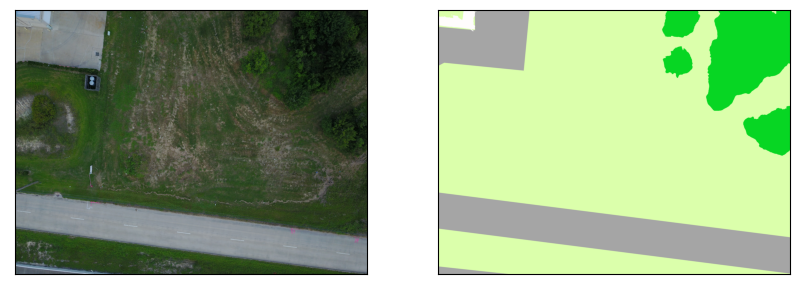

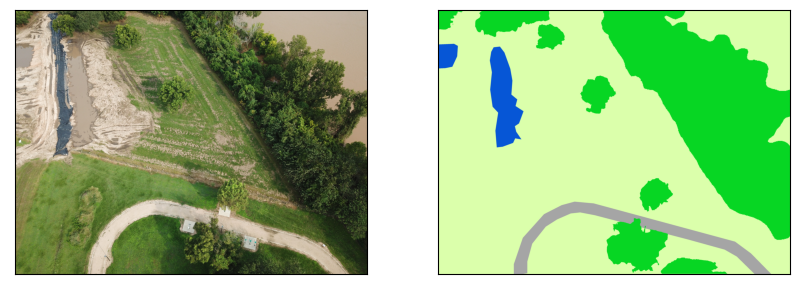

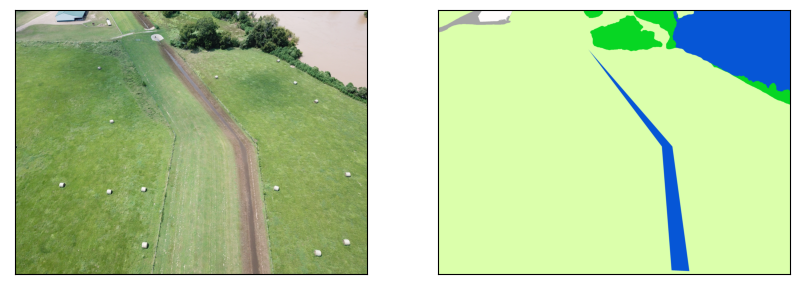

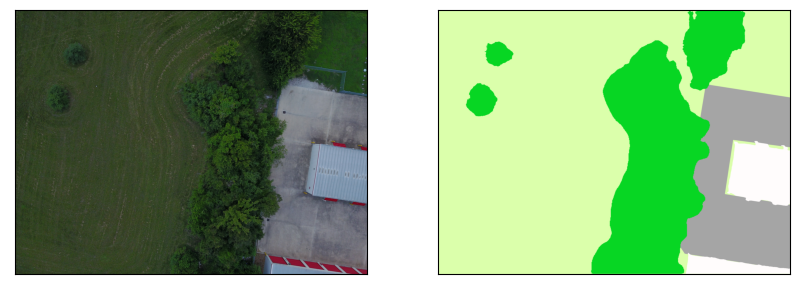

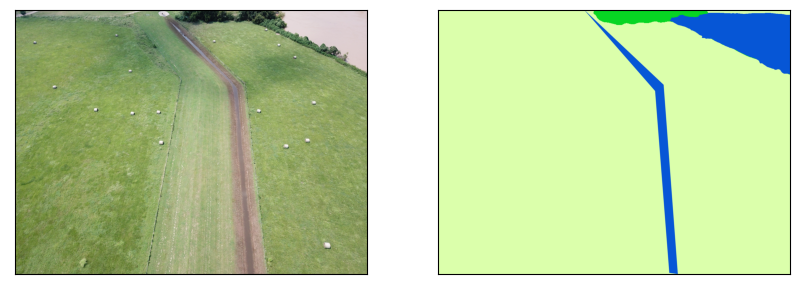

In [32]:
train_img = list(map(lambda x:Path(x).stem, glob.glob(f'{train_dir}/*.jpg')))
_train_img = np.random.choice(train_img,6)
for i in range(6):
    array_org, array_lbl = img_label(train_dir, _train_img[i])
    img_org, img_lbl = Image.fromarray(array_org), Image.fromarray(array_lbl)
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
    axes[0].imshow(img_org)
    axes[1].imshow(colorize_labels(img_lbl))
    hide_ticks_labels(axes[0])
    hide_ticks_labels(axes[1])


## Percent of images with different Labels

Create a random sampling of size 100 of the dataset with similar pre-processing steps as in the actual Dataset (FloodNetDataset below). In that random sample check the presence of different classes.

In [53]:
category_count = np.zeros(10)
_train_img = np.random.choice(train_img,100)

for i in range(len(_train_img)):
    array_org, array_lbl = img_label(train_dir, _train_img[i])
    array_org = transforms.ToTensor()(array_org)[None,:]
    i, j, h, w = transforms.RandomCrop.get_params(array_org, output_size=(1024,1536))
#     array_org = TF.crop(array_org, i, j, h, w)
    array_lbl = TF.crop(torch.Tensor(array_lbl).long(), i, j, h, w)
    for i in range(10):
        if torch.sum(array_lbl==i)>0:
            category_count[i] += 1

In [54]:
category_count

array([ 3.,  3., 16.,  8., 23., 24., 56.,  9.,  8., 92.])

# 3. Define Dataset

Dataset class for pre-processing and loading the files. The pre-processing steps involve the following:
1. Resize both the label and original image to half their size. This step is so that they a large enough area can fit in memory during training. Remember to use nearest label for interpolation while resizing GT image.
2. Convert to tensor and normalize the original image using the imagenet mean and std
3. Crop a random (512,768) sized image from the original and GT image pairs.

Note that more data augmentation steps such as horizontal, vertical flip can be applied to the dataset to increase effective dataset size.


In [8]:
class FloodNetDataset(Dataset):
    
    def __init__(self, dirpath, limit_data=None):
        self.dirpath = Path(dirpath)
        self.image_files = list(map(lambda x: Path(x).stem, glob.glob(f'{dirpath}/*.jpg')))
        
        if limit_data:
            self.image_files = self.image_files[:limit_data]
        
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        self.inverse_transform = transforms.Compose([
                                transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
                            ])
        
        self.resize_dims = (1500,2000)
        self.resize = transforms.Compose([transforms.Resize(size = self.resize_dims)])
        
#         org = np.array(Image.open(self.dirpath/f'{self.image_files[0]}.jpg').convert('RGB'))
#         org = self.transform(org)
#         i, j, h, w = transforms.RandomCrop.get_params(org, output_size=(512,768))
#         self.i, self.j, self.h, self.w = i,j,h,w
        
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, index):
        image_file = self.image_files[index]
        org = np.array(Image.open(self.dirpath/f'{image_file}.jpg').convert('RGB'))
        label = np.array(Image.open(self.dirpath/f'{image_file}_lab.png'))
        org = self.resize(self.transform(org))
#         print(label.shape)
        label = cv2.resize(label, (self.resize_dims[1],self.resize_dims[0]), interpolation=cv2.INTER_NEAREST)
        label = torch.Tensor(label).long()

        
        i, j, h, w = transforms.RandomCrop.get_params(org, output_size=(512,768))
        org = TF.crop(org, i, j, h, w)
        label = TF.crop(label, i, j, h, w)

        return org, label




In [9]:
dataset = FloodNetDataset(train_dir, 30)

In [10]:
dataset[0][1].shape, dataset[0][0].shape

(torch.Size([512, 768]), torch.Size([3, 512, 768]))

Visualize the dataset images to check if everything is OK.

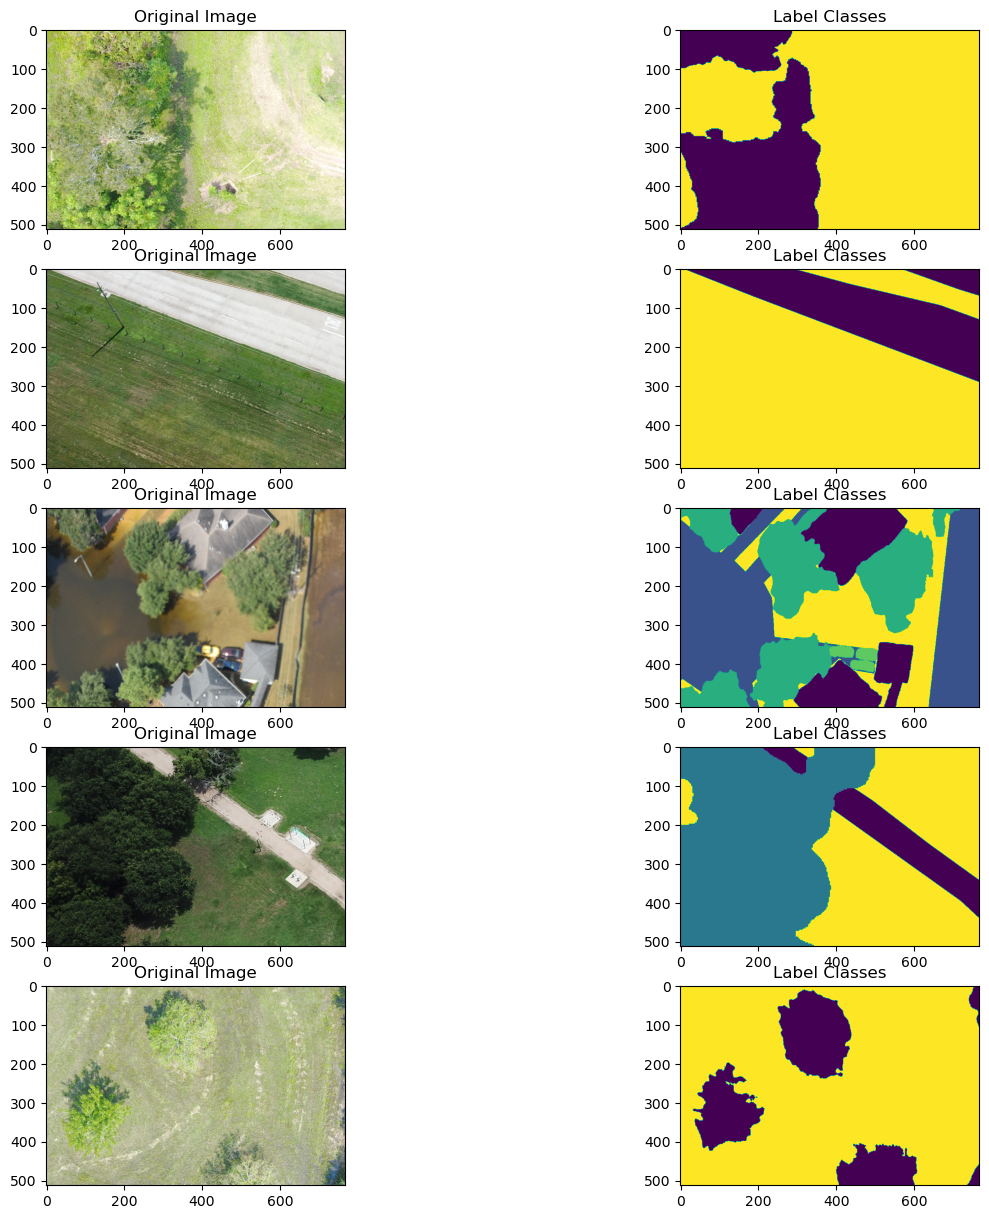

In [11]:
num_display = 5
fig, axes = plt.subplots(num_display, 2, figsize=(15, 15))

for i in range(num_display):
    org, label = dataset[i]
    org = dataset.inverse_transform(org).permute(1,2,0)

    axes[i,0].imshow(org)
    axes[i,0].set_title("Original Image")
    axes[i,1].imshow(label)
    axes[i,1].set_title("Label Classes")

# 4. Define Model

In [9]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [10]:
num_classes=10
model = UNet(num_classes=num_classes).to(device)

In [ ]:
data_loader = DataLoader(dataset, batch_size=1)
print(len(dataset), len(data_loader))

X, Y = next(iter(data_loader))
print(X.shape, Y.shape)

In [ ]:
# Y_pred = model(X.to(device))
# print(Y_pred.shape)

# 5. Train the model

In [14]:
batch_size = 6

epochs = 20
lr = 0.01

In [15]:
LIMIT_DATA_TRAIN = 600
LIMIT_DATA_VAL = 6
train_dataset = FloodNetDataset(train_dir, limit_data=LIMIT_DATA_TRAIN)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = FloodNetDataset(val_dir, limit_data=LIMIT_DATA_VAL)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = FloodNetDataset(test_dir)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = ExponentialLR(optimizer, gamma=0.95)

In [ ]:
step_losses = []
train_epoch_losses = []
val_epoch_losses = []

In [ ]:
for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    for X, Y in tqdm(train_data_loader, total=len(train_data_loader), leave=False):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
    scheduler.step()
    train_epoch_losses.append(epoch_loss/len(train_data_loader))
    
    epoch_loss = 0
    for X, Y in tqdm(val_data_loader, total=len(val_data_loader), leave=False):
        X, Y = X.to(device), Y.to(device)
        with torch.no_grad():
            Y_pred = model(X)
            loss = criterion(Y_pred, Y)
        epoch_loss += loss.item()
    val_epoch_losses.append(epoch_loss/len(val_data_loader))
    
    print(f"Epoch {epoch}: ", f"train loss: {train_epoch_losses[-1]}", f"val loss: {val_epoch_losses[-1]}")


In [ ]:


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(train_epoch_losses)
axes[1].plot(val_epoch_losses)

In [ ]:
model_name = f"UNet_{LIMIT_DATA_TRAIN}_random_crop.pth"
torch.save(model.state_dict(), model_name)

In [ ]:
# !rm *.pth

# 6. Check model predictions


In [11]:
model_path = "/kaggle/working/UNet_600_random_crop.pth"
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
X,Y = next(iter(test_data_loader))
X.shape, Y.shape

In [18]:
Y_pred = model_(X.to(device))
Y_pred.shape

In [22]:
Y_pred = torch.argmax(Y_pred, dim=1)
org = dataset.inverse_transform(X).permute(0,2,3,1)

In [23]:

def colorize_labels(im, colors=None, num_categories=10):
    # convert image to numpy array
    np_img = np.array(im)

    img_rgb_seg = np.zeros(np_img.shape + (3,), np.uint8) #initialize img
    if not colors:
        colors = [(0,0,0), #Background : black
                  (255,0,0), #Building Flooded : red
                  (255,252,252), #Building Non-Flooded : white
                  (255,191,0), #Road Flooded : orange
                  (165,165,165), #Road Non-Flooded : grey
                  (6,86,214), #Water : blue
                  (7,214,35), #Tree : green
                  (255,33,229), #Vehicle : pink
                  (0,191,255), #Pool : light blue
                  (219, 255, 171)  #Grass : light green
                 ]
    
    for i in range(num_categories):  # assign color to category labels
        img_seg = (np_img==i)
        img_rgb_seg[img_seg,:] = colors[i]

    # return RGB image
    return img_rgb_seg
    

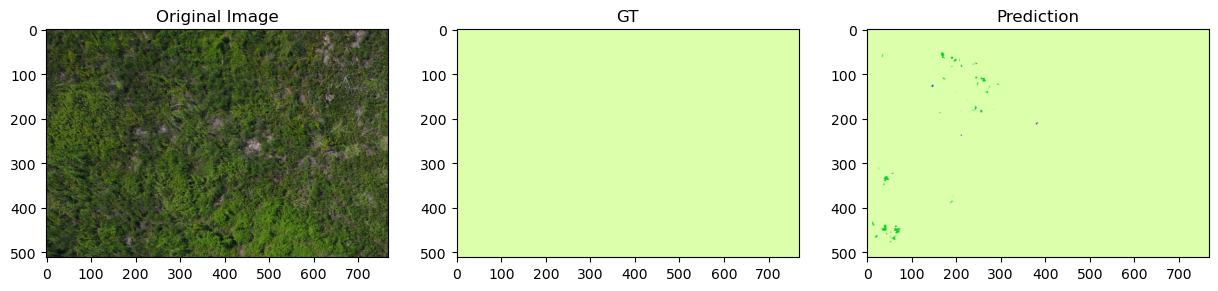

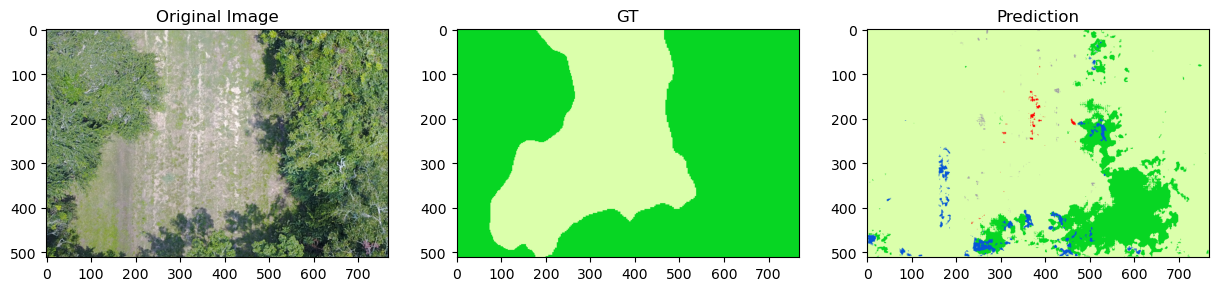

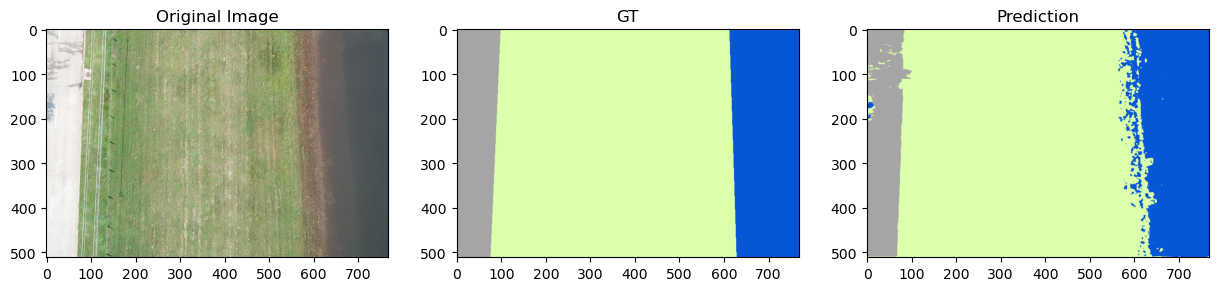

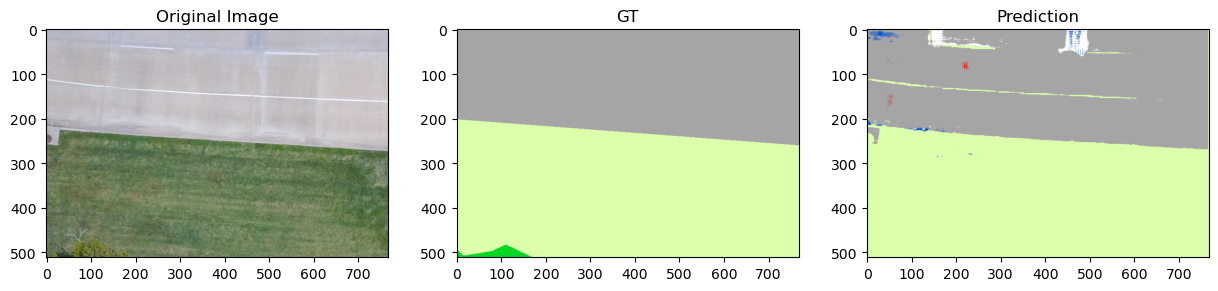

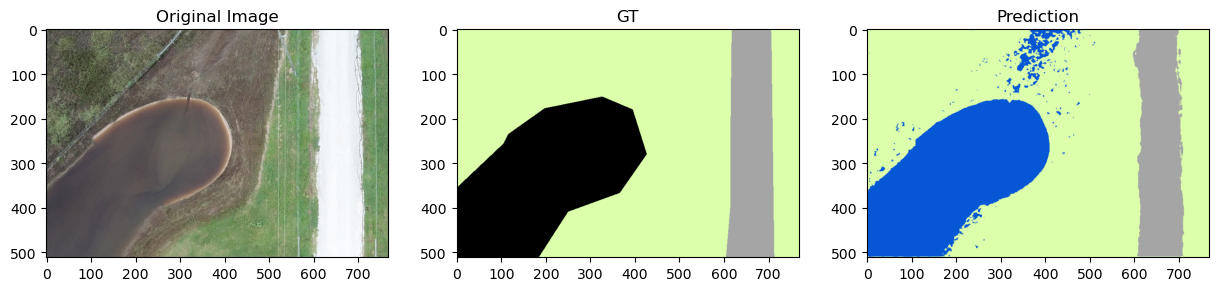

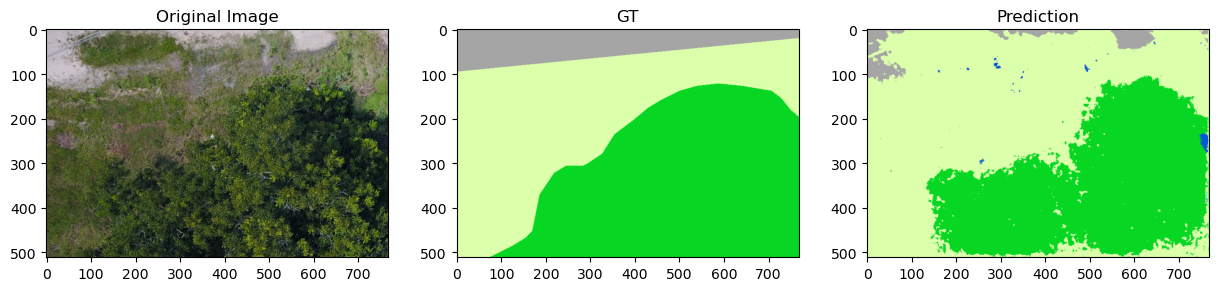

In [24]:
num_display = 6
for i in range(num_display):
    fig, axes = plt.subplots(1, 3, figsize=(15, 15))

#     org, label = dataset[i]
#     org = dataset.inverse_transform(org).permute(1,2,0)

    axes[0].imshow(org[i])
    axes[0].set_title("Original Image")
    axes[1].imshow(colorize_labels(Y[i]))
    axes[1].set_title('GT')
    axes[2].imshow(colorize_labels(Y_pred[i]))
    axes[2].set_title("Prediction")

## Test on UC Merced Dataset

In [ ]:
test_set = glob.glob('../data/UCMerced_LandUse/Images/sparseresidential/*.tif')

In [ ]:
test_set

In [ ]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])

In [ ]:
!shasum UNet_600_random_crop.pth 